In [1]:
#importing the necessary libraries
import os
import re
import numpy as np
import pandas as pd
#from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
#Read the file
df_= pd.read_csv("Data/url_features_dataset.csv")
df_.head(5)

,original_url,url_length,domain_length,path_length,query_length,subdomain_count,dot_count,dash_count,underscore_count,slash_count,...,has_suspicious_keywords,is_https,is_http,url_entropy,domain_entropy,vowel_count,vowel_ratio,consecutive_char_count,max_consecutive_chars,label
0,0000111servicehelpdesk.godaddysites.com,39,0,39,0,1,2,0,0,0,...,0,0,0,4.045286,3.022055,10,0.256410,3,2,0
1,000011accesswebform.godaddysites.com,36,0,36,0,1,2,0,0,0,...,0,0,0,3.974938,3.022055,9,0.250000,5,2,0
2,00003.online,12,0,12,0,0,1,0,0,0,...,0,0,0,2.751629,0.721928,3,0.250000,1,2,0
3,0009servicedeskowa.godaddysites.com,35,0,35,0,1,2,0,0,0,...,0,0,0,3.943289,3.022055,11,0.314286,2,2,0
4,000n38p.wcomhost.com,20,0,20,0,1,2,0,0,0,...,0,0,0,3.546439,2.750000,3,0.150000,1,2,0


In [3]:
#label balance/distribution
print(df_['label'].value_counts())

label
1    427028
0    394982
Name: count, dtype: int64


In [4]:
#Equally sampling 50% of the dataset because I am experimenting and tuning the models for prototyping and feature selection
df_0 = df_[df_['label'] == 0].sample(frac=0.50, random_state=42)
df_1 = df_[df_['label'] == 1].sample(frac=0.50, random_state=42)
df = pd.concat([df_0, df_1]).sample(frac=1, random_state=42)

In [5]:
#Ensuring that there are no null values 
df.isna().sum()
#Confirmed that there are no null values

original_url                 0
url_length                   0
domain_length                0
path_length                  0
query_length                 0
subdomain_count              0
dot_count                    0
dash_count                   0
underscore_count             0
slash_count                  0
question_count               0
equal_count                  0
at_count                     0
ampersand_count              0
exclamation_count            0
space_count                  0
tilde_count                  0
comma_count                  0
plus_count                   0
asterisk_count               0
hash_count                   0
dollar_count                 0
percent_count                0
hex_encoding_count           0
has_hex_encoding             0
digit_count                  0
digit_ratio                  0
letter_count                 0
letter_ratio                 0
domain                      15
is_common_tld                0
is_suspicious_tld            0
param_co

In [6]:
#Getting the features for the model prepping
features = [
    'url_length', 'domain_length', 'path_length', 'query_length', 'subdomain_count',
    'dot_count', 'dash_count', 'underscore_count', 'question_count', 'slash_count',
    'at_count', 'ampersand_count', 'exclamation_count', 'space_count', 'tilde_count', 'comma_count',
    'plus_count', 'asterisk_count', 'hash_count', 'dollar_count', 'percent_count', 'hex_encoding_count',
    'has_hex_encoding', 'digit_count', 'digit_ratio', 'letter_count', 'letter_ratio', 'is_common_tld', 
    'is_suspicious_tld', 'param_count', 'suspicious_keyword_count', 'has_suspicious_keywords',
    'is_https', 'is_http', 'url_entropy', 'domain_entropy', 'vowel_count', 'vowel_ratio', 'consecutive_char_count',
    'max_consecutive_chars'
]

In [7]:
#Model Prepping
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
import xgboost as xgb

X = df[features]
y = df['label']

models = {
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "RandomForest": RandomForestClassifier(),
    "SVM": LinearSVC(),
    "XGBoost": xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False)
}

In [8]:
results = {}

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

#Scling the features for models sensitive to feature scales
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

for model_name, model in models.items():
    #Trying to see the issue- optimization
    print(f"Training {model_name}...")
    #Train the model
    model.fit(X_train_scaled, y_train)

    print(f"{model_name} done")

    #predit on the test set
    y_pred = model.predict(X_test_scaled)

    #Compute evaluation metrics
    res = classification_report(y_test, y_pred, output_dict=True)

    results[model_name] = {
        'accuracy': res['accuracy'],
        'macro_f1': res['macro avg']['f1-score'],
        'cl0_f1': res['0']['f1-score'],
        'cl1_f1': res['1']['f1-score'],
        'cl0_precision': res['0']['precision'],
        'cl1_precision': res['1']['precision'],
        'cl0_recall': res['0']['recall'],
        'cl1_recall': res['1']['recall'],
        'support0': res['0']['support'],
        'support1': res['1']['support']
    }

#Converting results into a pandas.Dataframe for easier comparison
results_df = pd.DataFrame(results).T

#Print the DataFrame
print(results_df)


Training LogisticRegression...
LogisticRegression done
Training RandomForest...
RandomForest done
Training SVM...
SVM done
Training XGBoost...


c:\Users\MOSAKU\miniconda3\envs\myenv\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:31:10] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost done
                    accuracy  macro_f1    cl0_f1    cl1_f1  cl0_precision  \
LogisticRegression  0.849673  0.849156  0.840326  0.857987       0.856541   
RandomForest        0.944964  0.944802  0.941811  0.947794       0.955427   
SVM                 0.848420  0.847812  0.838190  0.857434       0.858823   
XGBoost             0.939380  0.939155  0.935449  0.942860       0.955994   

                    cl1_precision  cl0_recall  cl1_recall  support0  support1  
LogisticRegression       0.843780    0.824714    0.872680   39427.0   42774.0  
RandomForest             0.935828    0.928577    0.960069   39427.0   42774.0  
SVM                      0.839660    0.818525    0.875976   39427.0   42774.0  
XGBoost                  0.925258    0.915768    0.961145   39427.0   42774.0  


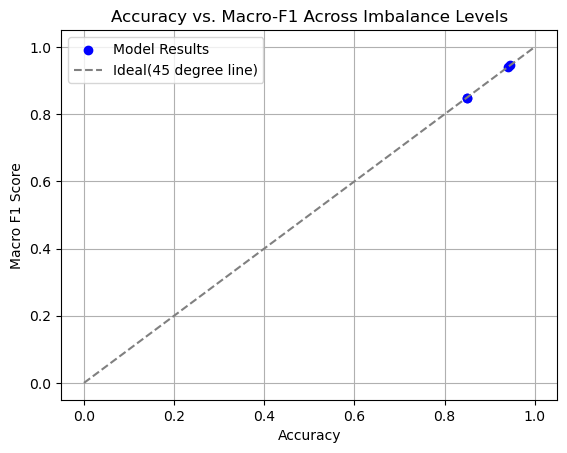

In [9]:
accuracy, f1 = zip(*[(v['accuracy'], v['macro_f1']) for v in results.values()])

plt.figure()
plt.scatter(accuracy,f1,label='Model Results', color='blue')
plt.plot([0,1], [0,1], linestyle='--', color='gray', label = 'Ideal(45 degree line)')
plt.xlabel('Accuracy')
plt.ylabel('Macro F1 Score')
plt.title('Accuracy vs. Macro-F1 Across Imbalance Levels')
plt.legend()
plt.grid(True)
plt.show()